In [103]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import sklearn
from sklearn import metrics
import pydicom
from matplotlib.patches import Rectangle

In [5]:
PATH = Path('/home/paperspace/data/pneumonia/toy')

In [72]:
file2target = pd.read_csv(PATH/'train_targets.csv')
file2boxes = pd.read_csv(PATH/'train_labels.csv')
file2boxes.set_index('patientId', inplace=True)
train_n = file2target.shape[0]
train_n

5000

In [7]:
val_idxs = get_cv_idxs(train_n)
val_idxs.shape

(1000,)

In [17]:
bs  = 128
arch = resnet50
sz=128

In [9]:
class OverSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, counts):
        indices =[]
        for idx, cnt in enumerate(counts):
            indices = indices +[idx]*int(cnt)
        self.ind_arr = np.array(indices)
        np.random.shuffle(self.ind_arr)
    
    def __len__(self):
        return len(self.ind_arr)
    
    def __iter__(self):
        return iter(self.ind_arr)

In [13]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train_targets.csv',
                                   val_idxs=val_idxs, bs=bs, tfms=tfms)
    '''train_ds = data.trn_ds
    train_dl = data.trn_dl
    all_y=np.ndarray(0)
    for x,y in train_dl.__iter__():
        all_y =np.append(all_y, y.cpu().numpy())

    weights = all_y*3 + 1
    sampler = OverSampler(weights)
    train_dl.sampler = sampler
    train_dl.batch_sampler=torch.utils.data.sampler.BatchSampler(sampler,bs,False)
    '''
    return data

In [160]:
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

epoch      trn_loss   val_loss   accuracy                  
    0      0.857904   1063.092768 0.786     



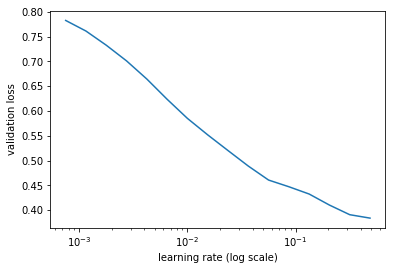

In [42]:
learn.lr_find()
learn.sched.plot()

In [161]:
%time learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.690799   0.567407   0.762     

CPU times: user 1.22 s, sys: 836 ms, total: 2.06 s
Wall time: 1.49 s


[array([0.56741]), 0.762]

In [162]:
learn.unfreeze()

In [169]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.053735   0.017966   0.996     



[array([0.01797]), 0.996]

In [21]:
def aur_roc(probs,y):
    probs_pneu = probs[:,1]
    fpr, tpr, tresh = sklearn.metrics.roc_curve(y, probs_pneu)
    auc = sklearn.metrics.auc(fpr,tpr)
    return auc

In [170]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0) #mean out of 5 transforms
accuracy_np(probs, y), aur_roc(probs,y)

(0.994, 0.9993934581706698)

In [171]:
preds = np.argmax(probs, axis=1)
np.where(preds != y)


(array([ 93, 306, 408, 488, 561, 726]),)

In [155]:
def display(file_name,ax=None):
    if ax is None:
        _,ax = plt.subplots(1,1)
    ax.imshow(PIL.Image.open(PATH/file_name))
    boxes =file2boxes['bboxes'].loc[str(Path(file_name).name)]
    if pd.isna(boxes):return
    bs = boxes.split()
    for idx in range(0,len(bs),4):
        x1,y1,x2,y2 = int(bs[idx]),int(bs[idx+1]),int(bs[idx+2]),int(bs[idx+3])
        ax.add_patch(Rectangle(xy=(x1,y1),width=x2-x1,height=y2-y1,alpha = 0.5, fill=False, color='red'))
    return (x1, y1,x2,y2)

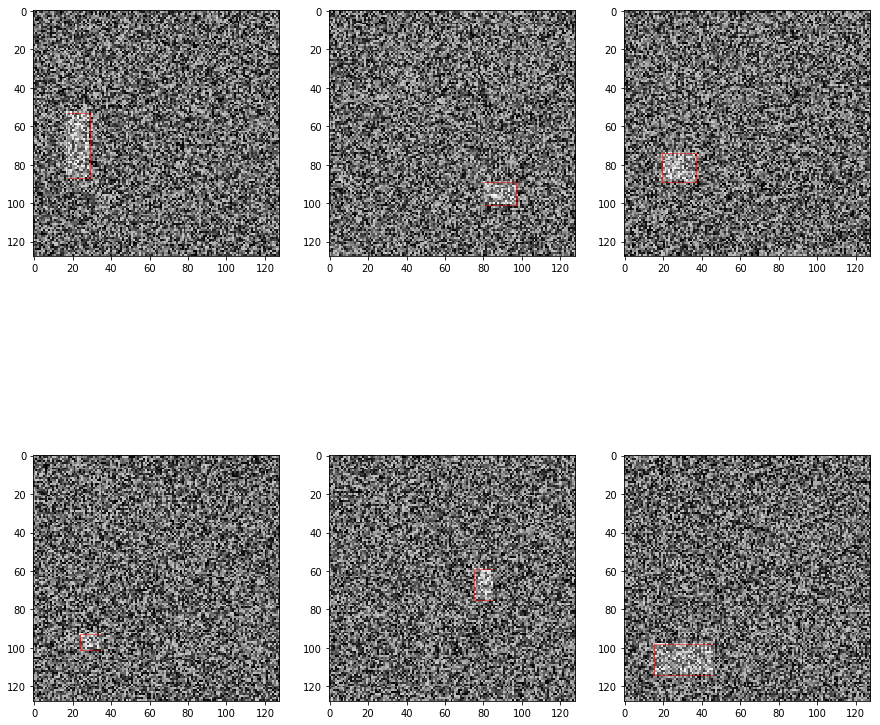

In [172]:
wrong_names = np.take(data.val_ds.fnames, np.where(preds!=y))[0]
_,axs = plt.subplots((len(wrong_names)+2)//3,3,figsize=(15,15))

for name, ax in zip(wrong_names,axs.flat):
    display(name, ax)

[[762   0]
 [ 10 228]]


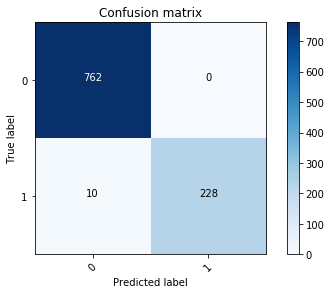

In [167]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, learn.data.classes)

In [25]:
learn.save('toy_res50')